# Stabilization

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [55]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from scipy.stats import zscore
from tkinter import font

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    return seed

# Set seed for reproducibility
seed = set_seed(42)


In [56]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

In [57]:
def _process_lvm_file(file_path, include_sample=True):
    """Helper function to process a single LVM file"""
    df = pd.read_csv(file_path, 
                   delimiter='\t',  
                   skiprows=22,     # Skip the header lines 
                   header=None,     
                   usecols=[1, 2, 3],  
                   decimal=',')     
    
    # Set proper column names
    df.columns = ['Frequency (GHz)', 'LG (mV)', 'HG (mV)']
    
    # Optionally add sample name from filename
    if include_sample:
        sample_name = os.path.splitext(os.path.basename(file_path))[0]
        df['Sample'] = sample_name
    
    return df

def load_lvm(input_path, include_sample=True):
    data_frames = []
    
    # Check if input_path is a file or directory
    if os.path.isfile(input_path):
        # Handle single file
        if input_path.endswith('.lvm'):
            data_frames.append(_process_lvm_file(input_path, include_sample))
    
    elif os.path.isdir(input_path):
        # Handle directory
        for file in os.listdir(input_path):
            if file.endswith('.lvm'):
                file_path = os.path.join(input_path, file)
                data_frames.append(_process_lvm_file(file_path, include_sample))
    
    if data_frames:  
        data = pd.concat(data_frames, ignore_index=True)
    else:
        data = pd.DataFrame()  
    
    return data

## Preprocessing Data - Dispersion
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [58]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)

    return results_df

## Pivoting Frequency values to columns

In [59]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [60]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_5_plastics/raw/B4_44.lvm'

df = load_lvm(input_path, include_sample=False)

# show random rows
# df.sample(15)
df.head()


,Frequency (GHz),LG (mV),HG (mV)
0,100.0,0.732511,29.910877
1,100.0,0.366256,35.038456
2,100.0,3.052130,4.761323
3,100.0,0.366256,10.377243
4,100.0,0.976682,25.393724


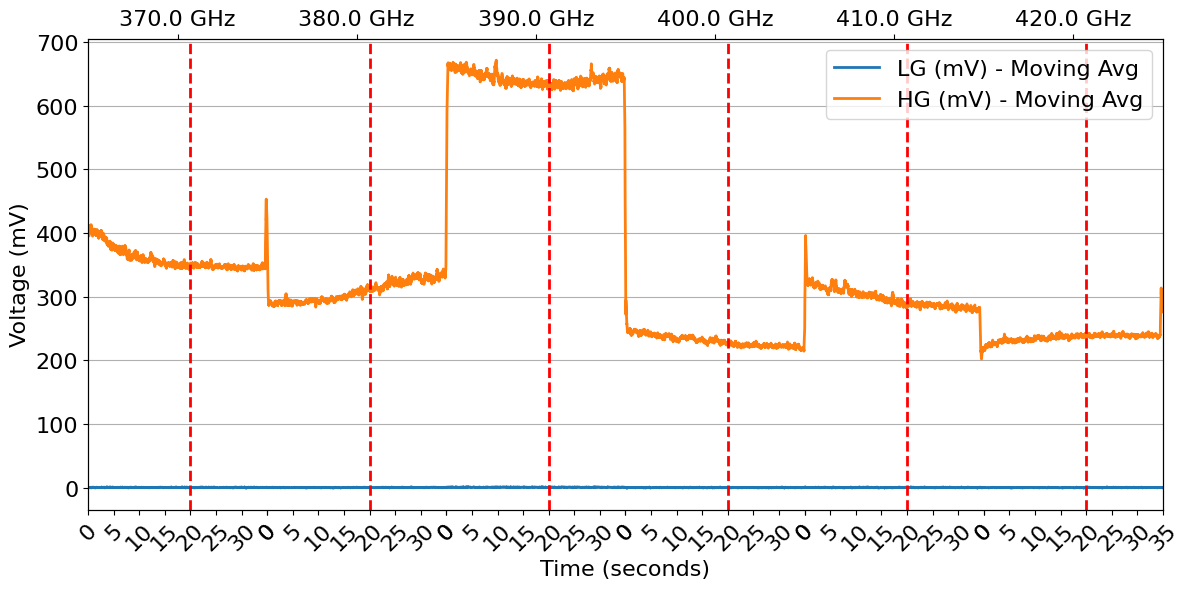

Stabilization plot saved as stabilization_plot.pdf


In [61]:


selected_freqs = [370.0, 380.0, 390.0, 400.0, 410.0, 420.0]
df_filtered = df[df['Frequency (GHz)'].isin(selected_freqs)].reset_index(drop=True)

window = 20
lg_ma = df_filtered['LG (mV)'].rolling(window, center=True).mean()
hg_ma = df_filtered['HG (mV)'].rolling(window, center=True).mean()

with PdfPages('stabilization_plot.pdf') as pdf:
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, lg_ma, label='LG (mV) - Moving Avg', color='tab:blue', linewidth=2)
    plt.plot(df_filtered.index, hg_ma, label='HG (mV) - Moving Avg', color='tab:orange', linewidth=2)
    # plt.title(f'HG and LG values (Moving Avg, window={window}) for B4 sample', fontsize=20)
    plt.xlabel('Time (seconds)', size=16)
    plt.ylabel('Voltage (mV)', size=16)
    plt.legend(fontsize=16)
    plt.grid(axis='y')
    plt.gca().set_facecolor('white')

    max_time = 35
    tick_interval = 5
    time_ticks = np.arange(0, max_time + 1, tick_interval)
    samples_per_freq = len(df_filtered) // len(selected_freqs)

    tick_positions = []
    tick_labels = []
    red_line_positions = []

    for i, freq in enumerate(selected_freqs):
        freq_start_idx = i * samples_per_freq
        for tick in time_ticks:
            tick_position = freq_start_idx + (tick / max_time) * samples_per_freq
            tick_positions.append(tick_position)
            tick_labels.append(str(tick))
            # Highlight every second '20' with a red vertical line
            if tick == 20:
                red_line_positions.append(tick_position)

    plt.xticks(tick_positions, tick_labels, fontsize=16, rotation=45)
    plt.xlim(0, len(df_filtered))

    # Draw red vertical lines at every '20' second tick
    for xpos in red_line_positions:
        plt.axvline(x=xpos, color='red', linestyle='--', linewidth=2, label='20s marker')

    ax = plt.gca()
    ax.tick_params(axis='both', labelsize=16) 
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    freq_positions = []
    freq_labels = []
    for i, freq in enumerate(selected_freqs):
        freq_start_idx = i * samples_per_freq
        freq_end_idx = (i + 1) * samples_per_freq
        mid_position = (freq_start_idx + freq_end_idx) / 2
        freq_positions.append(mid_position)
        freq_labels.append(f'{freq} GHz')

    ax2.set_xticks(freq_positions)
    ax2.set_xticklabels(freq_labels, fontsize=16)
    # ax2.set_xlabel('Frequency (GHz)', fontsize=20)

    plt.tight_layout()
    pdf.savefig(bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

print("Stabilization plot saved as stabilization_plot.pdf")